# Universal differential equation for SIR ODE model

In this notebook, we want to jointly estimate the parameter $\gamma$ of the known part of the mechanistic model and the parameters $\theta$ of the neural network, which is supposed to learn the unknown residual dynamics.

In [1]:
# SciML Tools
using OrdinaryDiffEq, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL

# Standard Libraries
using LinearAlgebra, Statistics, Random, Distributions

# External Libraries
using ComponentArrays, Lux, Zygote, Plots, StableRNGs
gr()

# Set a random seed for reproducible behaviour
rng = StableRNG(1111);

### Define the SIR dynamics and solve the ODE

In [2]:
function sir!(du, u, p, t)
    β, γ, N = p
    du[1] = -β*u[1]*u[2]/N
    du[2] = β*u[1]*u[2]/N - γ*u[2]
    du[3] = γ*u[2]
end

p_ODE = [0.6, 0.3, 1.0]
u0 = [0.999, 0.001, 0.0]
tspan = (0.0, 40.0);

In [3]:
prob = ODEProblem(sir!, u0, tspan, p_ODE)
sol = solve(prob, Tsit5(), abstol = 1e-12, reltol = 1e-12, saveat = 1.0);

### Add multiplicative log-normal noise

In [4]:
t = sol.t
X = Array(sol)
dist = LogNormal(0, 0.01)
noise = rand(rng, dist, size(X))
X_noisy = noise .* X;

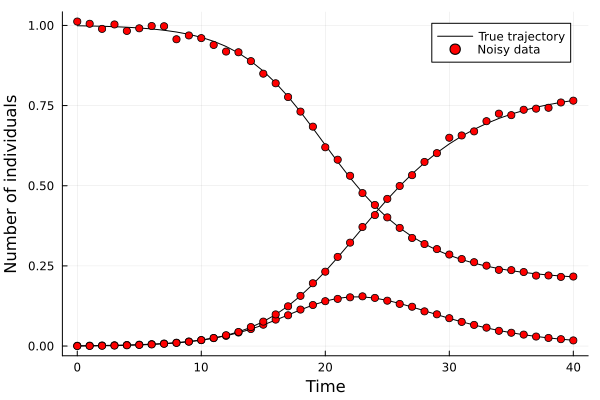

In [5]:
plot(t, X', xlabel = "Time", ylabel = "Number of individuals",
     color = :black, label=["True trajectory" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

### Set up the UDE

We set up our UDE by first defining the NN component and then the hybrid model $u'=f(u, \gamma)+\text{NN}(u, \theta)$.

In [6]:
# Define activation function
rbf(x) = exp.(-(x .^ 2))

# Multi-layer feed-forward neural network
model = Chain(Dense(2, 5, rbf), Dense(5, 5, rbf), Dense(5, 5, rbf), Dense(5, 2))

# Get initial parameters and state variables of the model
θ_init, st = Lux.setup(rng, model);

In [7]:
# Define the hybrid model
β, γ, N = p_ODE

function ude_dynamics!(du, u, p, t)
    nn = Lux.apply(model, u[1:2], p.nn, st)[1]   # Network prediction    
    du[1] = nn[1]
    du[2] = -p.γ*u[2] + nn[2] 
    du[3] = p.γ*u[2]
end

γ_init = 0.5
p_init = (nn = θ_init, γ = γ_init)
p_init = ComponentVector(p_init)
prob_ude = ODEProblem(ude_dynamics!, u0, tspan, p_init);

### Set up the training

In [8]:
function predict(p)   # p consists of the NN parameters θ and the mechanistic parameter γ of the ODE
    _prob = remake(prob_ude, p=p)
    Array(solve(_prob, Tsit5(), abstol = 1e-6, reltol = 1e-6, saveat = t,
                sensealg=QuadratureAdjoint(autojacvec=ReverseDiffVJP(true))))
end;

In [9]:
function loss(p)
    X̂ = predict(p)
    mean(abs2, X_noisy .- X̂)   # MSE loss
end;

In [10]:
losses = Float64[]

function callback(p, l)
    push!(losses, l)
    n_iter = length(losses)
    if n_iter % 50 == 0   
        println("Loss after $(n_iter) iterations: $(losses[end])")
    end
    return false
end;

### Train the UDE

In [11]:
adtype = AutoZygote()   # automatic differentiation
optf = OptimizationFunction((p, _) -> loss(p), adtype)
optprob = OptimizationProblem(optf, p_init);

In [12]:
res1 = solve(optprob, ADAM(), callback = callback, maxiters = 5000);

Loss after 50 iterations: 71.57410609708683
Loss after 100 iterations: 16.84768613657924
Loss after 150 iterations: 4.700954813857409
Loss after 200 iterations: 1.5323351583958842
Loss after 250 iterations: 0.5099214669534552
Loss after 300 iterations: 0.17071465587967624
Loss after 350 iterations: 0.05941589623842444
Loss after 400 iterations: 0.02316877020088021
Loss after 450 iterations: 0.01151532177057271
Loss after 500 iterations: 0.0078763296064651
Loss after 550 iterations: 0.00679102051284742
Loss after 600 iterations: 0.006485269403498065
Loss after 650 iterations: 0.006403470270437904
Loss after 700 iterations: 0.006381337404960145
Loss after 750 iterations: 0.006373733259670865
Loss after 800 iterations: 0.006369264905256384
Loss after 850 iterations: 0.006365311727470851
Loss after 900 iterations: 0.006361328000985304
Loss after 950 iterations: 0.00635721177049911
Loss after 1000 iterations: 0.0063529463963663034
Loss after 1050 iterations: 0.006348529818204387
Loss after 

In [13]:
optprob2 = OptimizationProblem(optf, res1.u)
res2 = solve(optprob2, LBFGS(), callback = callback, maxiters = 1500)
p_trained = res2.u;

Loss after 5050 iterations: 0.0022108194870059505
Loss after 5100 iterations: 0.0012893632423019751
Loss after 5150 iterations: 0.00033919303328477164
Loss after 5200 iterations: 0.0003166382730868141
Loss after 5250 iterations: 0.0001513370026083377
Loss after 5300 iterations: 7.81479214597614e-5
Loss after 5350 iterations: 7.344442277157882e-5
Loss after 5400 iterations: 7.143900389426949e-5
Loss after 5450 iterations: 6.261403223222525e-5
Loss after 5500 iterations: 5.780890093546484e-5
Loss after 5550 iterations: 5.375253518529849e-5
Loss after 5600 iterations: 5.026874094275357e-5
Loss after 5650 iterations: 4.858182265689671e-5
Loss after 5700 iterations: 4.7869568360029585e-5
Loss after 5750 iterations: 4.646080733870886e-5
Loss after 5800 iterations: 4.554695772465799e-5
Loss after 5850 iterations: 4.241380755046938e-5
Loss after 5900 iterations: 4.083141849658402e-5
Loss after 5950 iterations: 3.8458072714595043e-5
Loss after 6000 iterations: 3.369203983420535e-5
Loss after 60

### Visualize the results

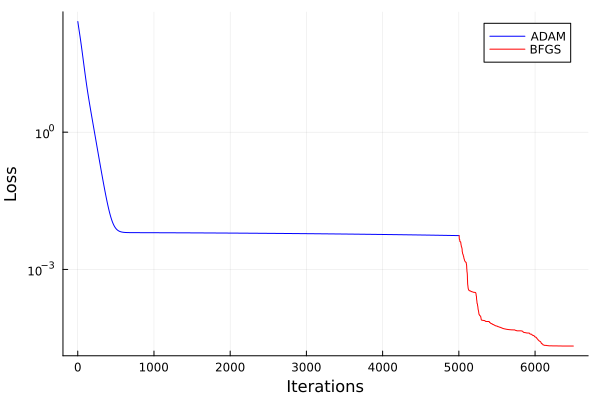

In [14]:
plot(1:5000, losses[1:5000], yaxis=:log10, xlabel="Iterations", ylabel="Loss", label="ADAM", color=:blue)
plot!(5001:length(losses), losses[5001:end], yaxis=:log10, label="BFGS", color = :red)

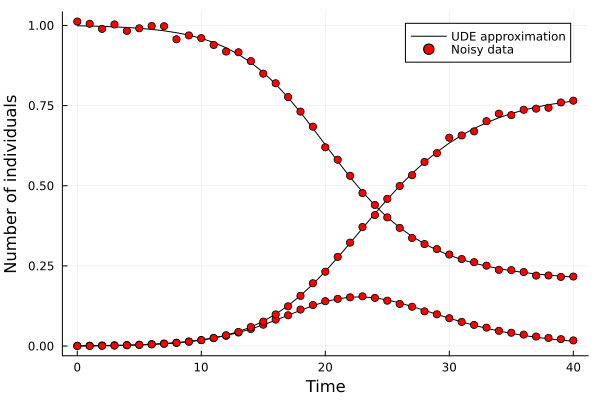

In [15]:
X̂ = predict(p_trained)
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
scatter!(t, X_noisy', color = :red, label=["Noisy data" nothing nothing])

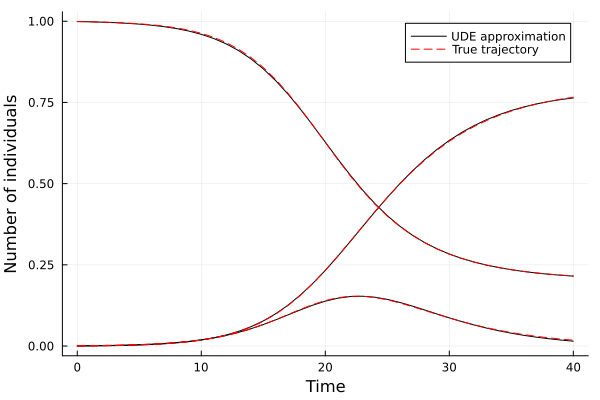

In [16]:
plot(t, X̂', xlabel = "Time", ylabel = "Number of individuals", color = :black,
     label = ["UDE approximation" nothing nothing])
plot!(t, X', color = :red, linestyle=:dash, label=["True trajectory" nothing nothing])

In [17]:
p_trained.γ

0.30102060339695524

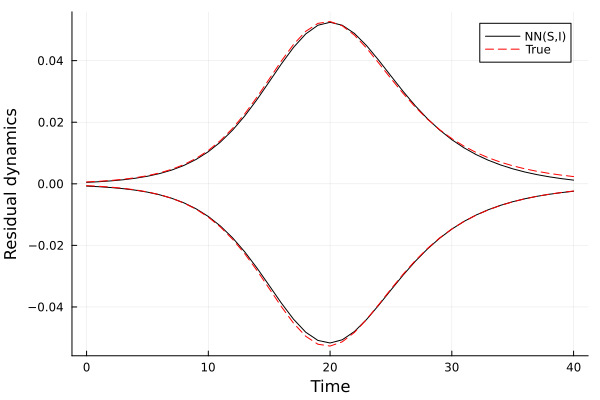

In [18]:
# True residual dynamics (i.e. interactions of predictors) along the true trajectory
dynamics_true = [-β/N * (X[1, :] .* X[2, :])'; β/N * (X[1, :] .* X[2, :])']
# Neural network guess along the true trajectory
dynamics_nn = Lux.apply(model, X[1:2, :], p_trained.nn, st)[1]

plot(t, dynamics_nn', xlabel = "Time", ylabel = "Residual dynamics", color = :black, label = ["NN(S,I)" nothing])
plot!(t, dynamics_true', color = :red, linestyle=:dash, label = ["True" nothing])

Here, due to the simplified learning task and NN, the mechanistic parameter $\gamma$ and the residual dynamics are correctly estimated.

We can also check how well the approximation of residual dynamics generalizes from the true trajectory to the rest of the domain.

In [19]:
s = range(0.0, stop=1.0, length=100)
i = range(0.0, stop=0.5, length=100)
grid = Iterators.product(s, i)

error_1(s, i) = abs(-β*s*i/N - Lux.apply(model, [s, i], p_trained.nn, st)[1][1])
errors_1 = [error_1(sk, ik) for (sk, ik) in grid]
error_2(s, i) = abs(β*s*i/N - Lux.apply(model, [s, i], p_trained.nn, st)[1][2])
errors_2 = [error_2(sk, ik) for (sk, ik) in grid]
clims = (0, max(maximum(errors_1), maximum(errors_2)));

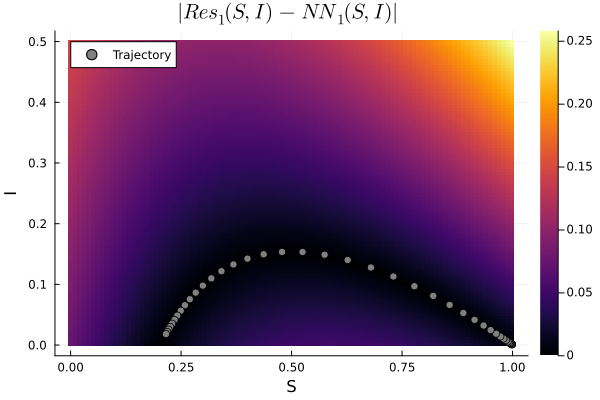

In [20]:
heatmap(s, i, errors_1', clims=clims, xlabel="S", ylabel="I", title="\$|Res_1(S,I)-NN_1(S,I)|\$")
scatter!(X[1, :], X[2, :], label="Trajectory", color=:grey)

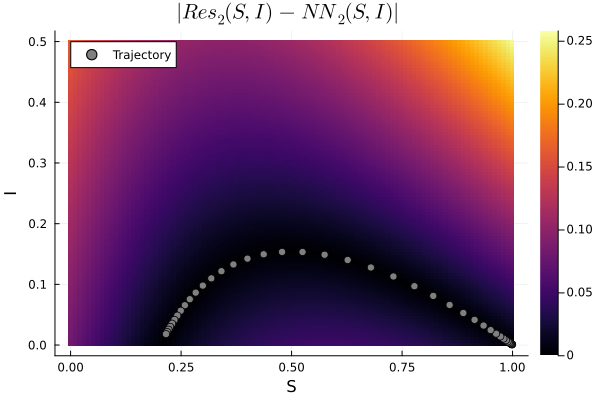

In [21]:
heatmap(s, i, errors_2', clims=clims, xlabel="S", ylabel="I", title="\$|Res_2(S,I)-NN_2(S,I)|\$")
scatter!(X[1, :], X[2, :], label="Trajectory", color=:grey)